This notebook is a tempate to work on an illustration of transfer learning. 
It should use:
- a pre-trained Model from Keras (Xception at first)
- a dataset of images of casting products (impellers for submersible pumps), 
some of which have a defect (available in `casting_512x512.zip` 
or on [Kaggle](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product))

Add a simple classification layer to the pre-trained model, and train it with 
the pictures.
When this works, try different tweaks such as different models, data augmentation, 
etc. 

The code can be adapted from: 
- Keras tutorial https://keras.io/guides/transfer_learning/
- Kaggle tutorial https://www.kaggle.com/code/digantdixit/transfer-learning-cnn-for-beginners

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras, os
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.models import Sequential
import tensorflow as tf

2025-10-12 02:30:47.492956: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Load your dataset from the directory `casting_512x512`
# by using keras.preprocessing.image.ImageDataGenerator
# think about rescaling and train/test splitting

train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
train = train_data_gen.flow_from_directory(
    directory="casting_512x512",
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
    subset="training",
)

test = train_data_gen.flow_from_directory(
    directory="casting_512x512",
    target_size=(256, 256),
    batch_size=32,
    class_mode="binary",
    subset="validation",
)

# check that you have 2 classes
print(f"Classes found in train : {train.class_indices}")
print(f"Classes found in test : {test.class_indices}")

# plot a few pictures to see what you deal with
# Plot a few images of class 0 and class 1
def plot_images(data, class_label, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    fig.suptitle(f'Class {class_label}', fontsize=20)
    count = 0
    for images, labels in data:
        for i in range(len(labels)):
            if labels[i] == class_label:
                axes[count].imshow(images[i])
                axes[count].axis('off')
                count += 1
                if count == num_images:
                    return

plot_images(train, class_label=0)
plot_images(train, class_label=1)

FileNotFoundError: [Errno 2] No such file or directory: 'casting_512x512'

In [ ]:
# Load a pretrained model from Keras, for example Xception
# think about values of 'input_shape', 'weights', and 'include_top'

from tensorflow.keras.applications import Xception
# ! the images are 256 by 256 with 3 channels of colors therefore the input_shape is (256, 256, 3)
# ! we don't want the top layer of the model so we can add ours
# ! we want to use the weights of the model that was trained on imagenet
xcept = Xception(input_shape=(256, 256, 3), include_top=False, weights="imagenet")

In [ ]:
# Use the code from  Keras transfer learning tutorial
# https://keras.io/guides/transfer_learning/
# Adapt it to your case

xcept.trainable = False
inputs = keras.Input(shape=(256, 256, 3))
# Freeze weights of the pretrained model
x = xcept(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# Replace last layer with a 2-class classifier (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
# Compile it
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
# print model summary
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 8, 8, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,863,529 (79.59 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

None


In [ ]:
# Fit your model for a few epochs using 'train' data and 'test' validation data
model.fit(
    train,
    epochs=10,
    steps_per_epoch=7,
    validation_data=test,
    validation_steps=len(test),
)

Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1732287305.902846 1598979 service.cc:148] XLA service 0x75e068002d10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732287305.902884 1598979 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-22 15:55:06.004401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732287306.692913 1598979 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-22 15:55:13.273258: W exter

7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5527 - loss: 0.6424 - val_accuracy: 0.6216 - val_loss: 0.5913
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5912 - loss: 0.5801
Epoch 3/10
2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6953 - loss: 0.5548

2024-11-22 15:55:21.055714: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-22 15:55:21.055788: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6826 - loss: 0.5415 - val_accuracy: 0.6641 - val_loss: 0.5294
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6993 - loss: 0.5145
Epoch 5/10


2024-11-22 15:55:28.223068: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.7863 - loss: 0.4510 - val_accuracy: 0.7297 - val_loss: 0.4909
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.7340 - loss: 0.4685
Epoch 7/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.7812 - loss: 0.4488

2024-11-22 15:55:29.743034: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-11-22 15:55:29.743064: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141
2024-11-22 15:55:29.743077: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6476875867373566610


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7148 - loss: 0.4836 - val_accuracy: 0.7413 - val_loss: 0.4587
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.7617 - loss: 0.4255
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.8162 - loss: 0.3990 - val_accuracy: 0.7606 - val_loss: 0.4328
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8168 - loss: 0.3886


2024-11-22 15:55:32.707422: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141
2024-11-22 15:55:32.707452: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6476875867373566610


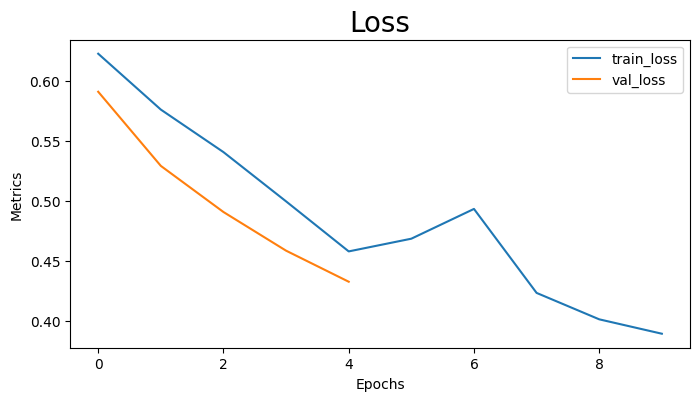

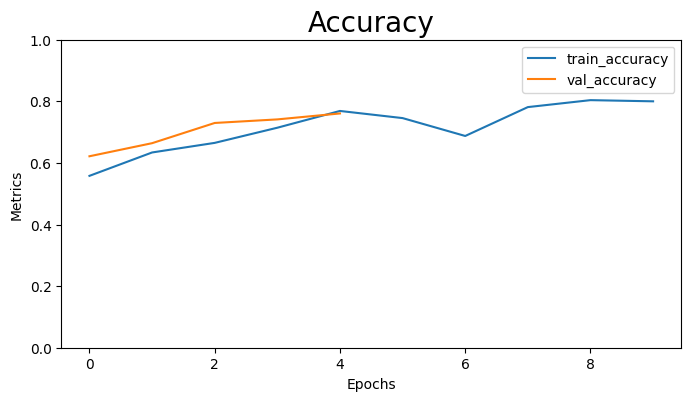

In [ ]:
# plot loss and  accuracy as a function of epochs
# plot loss
plt.subplots(figsize=(8, 4))
X = range(1, 1 + len(model.history.epoch))
plt.plot(model.history.history["loss"])
plt.plot(model.history.history["val_loss"])
plt.title("Loss", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend(labels=["train_loss", "val_loss"])
plt.show()

# plot accuracy
plt.subplots(figsize=(8, 4))
plt.plot(model.history.history["accuracy"])
plt.plot(model.history.history["val_accuracy"])
plt.title("Accuracy", fontsize=20)
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.ylim(0, 1)
plt.legend(labels=["train_accuracy", "val_accuracy"])
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 330ms/step
Predicted: [0], True: 0
Predicted: [0], True: 0
Predicted: [0], True: 0
Predicted: [1], True: 0
Predicted: [0], True: 0


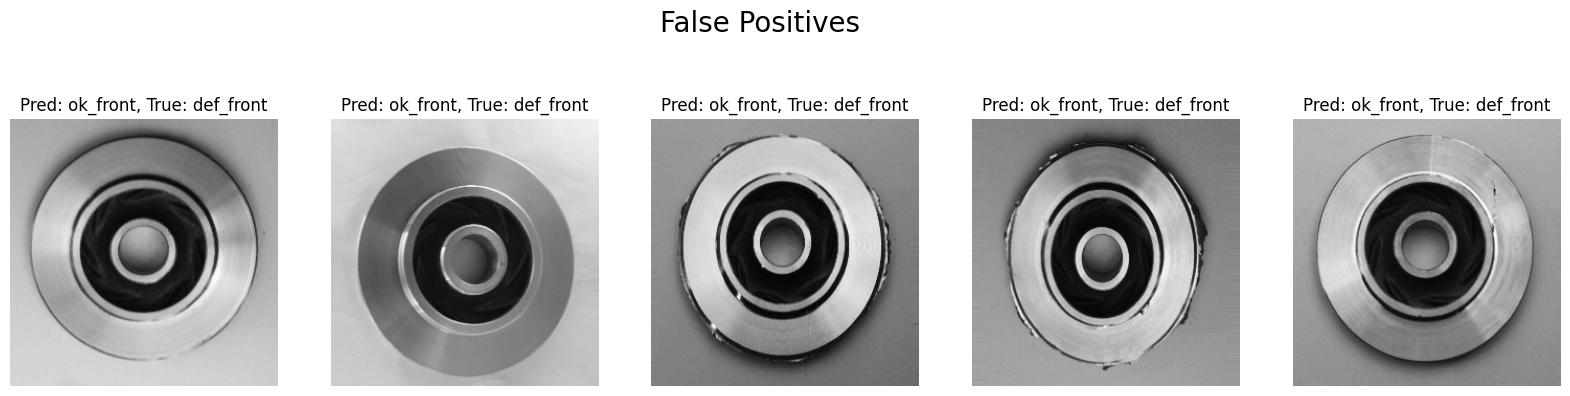

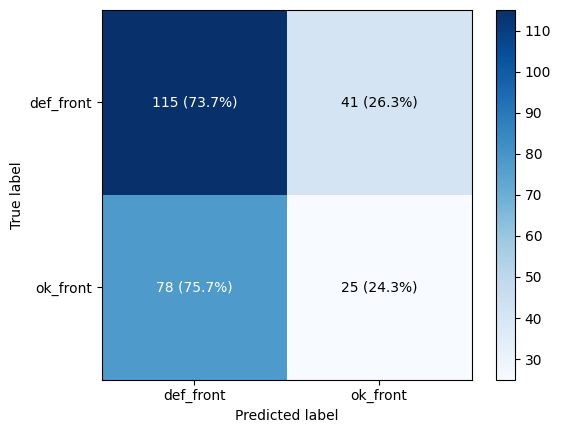

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Accuracy: 0.5868725868725869
Precision: 0.4696969696969697
Recall: 0.30097087378640774
F1 Score: 0.3668639053254438


In [ ]:
# plot the result of some predictions. Plot some false positives.
# Get predictions from the model
predictions = model.predict(test)
predicted_classes = np.where(predictions > 0.5, 1, 0)

for i in range(5):
    print(f"Predicted: {predicted_classes[i]}, True: {test.classes[i]}")

# Get true labels
true_classes = test.classes
class_labels = list(test.class_indices.keys())

# Find false positives
false_positives = np.where((predicted_classes == 1) & (true_classes == 0))[0]

# Plot some false positives
def plot_false_positives(data, false_positives, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    fig.suptitle('False Positives', fontsize=20)
    for i, idx in enumerate(false_positives[:num_images]):
        img, label = data[idx]
        axes[i].imshow(img[i])
        axes[i].axis('off')
        axes[i].set_title(f'Pred: {class_labels[1]}, True: {class_labels[0]}')

def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    # Add percentages
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    thresh = cm.max() / 2.
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f'{cm[i, j]} ({cm_perc[i, j]:.1f}%)',
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    plt.show()

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(model, test):
    predictions = model.predict(test)
    y_pred = np.where(predictions > 0.5, 1, 0)
    y_true = test.classes
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1


plot_false_positives(test, false_positives)
plot_confusion_matrix(true_classes, predicted_classes, class_labels)

accuracy, precision, recall, f1 = calculate_metrics(model, test)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

In [ ]:
# Turn your code into functions easy to call, so that you can try
# multiple parameters and make a table with different scenarios

def load_data(BATCH_SIZE=32):
    train_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)
    
    
    train = train_data_gen.flow_from_directory(
        directory="casting_512x512",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode="binary",
        subset="training",
    )

    test = train_data_gen.flow_from_directory(
        directory="casting_512x512",
        target_size=(256, 256),
        batch_size=BATCH_SIZE,
        class_mode="binary",
        subset="validation",
    )    
    return train, test


def train_model(model, train, test, EPOCHS=10, STEPS_PER_EPOCH=7):
    model.trainable = False
    inputs = keras.Input(shape=(256, 256, 3))
    x = model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()],  
    )

    history = model.fit(
        train,
        epochs=EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_data=test,
        validation_steps=len(test),
    )
    return history


train, test = load_data(BATCH_SIZE=16)


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.


Ideas of possible variations to see how performance changes:
- With different kinds of image classification models
- With or without data augmentation
- With a different number of input pictures

Possible output:
|Scenario|Type&puncsp;of&puncsp;model|Data&puncsp;augmentation|Number&puncsp;of&puncsp;training&puncsp;images|Number&puncsp;of&puncsp;test&puncsp;images|Training&puncsp;accuracy|Testing&puncsp;accuracy|Training&puncsp;duration|
|-|-|-|-|-|-|-|-|
|1..n|Xception,&puncsp;MobileNet,&puncsp;ResNet,&puncsp;...|y/n|5%&puncsp;10%&puncsp;50%&puncsp;80%&puncsp;of&puncsp;total|||||

Other ideas: 
- Use raw classifications from the pre-trained model as a proxy metric to ok/defect
- Look into explainability for computer vision algorithms
- Try large multimodal models


In [ ]:
import wandb
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3

wandb.init(project="bin_class_dataset_model_comparison")

bsizes = {16, 32}
models = { "Xception": Xception(input_shape=(256, 256, 3), include_top=False, weights="imagenet"),
           "ResNet50": ResNet50(input_shape=(256, 256, 3), include_top=False, weights="imagenet"),
           "VGG16": VGG16(input_shape=(256, 256, 3), include_top=False, weights="imagenet"),
           "InceptionV3": InceptionV3(input_shape=(256, 256, 3), include_top=False, weights="imagenet")}

for batch_size in bsizes:
    for model_name, model in models.items():
        wandb_run = wandb.init(project="bin_class_dataset_model_comparison", name=model_name+"_"+str(batch_size))
        
        train, test = load_data(BATCH_SIZE=batch_size)
        history = train_model(model, train, test, EPOCHS=10, STEPS_PER_EPOCH=7)
        keys = list(history.history.keys())
        print(keys)

        accuracy = history.history["accuracy"][-1]
        loss = history.history["loss"][-1]
        precision = history.history[keys[3]][-1]
        recall = history.history[keys[4]][-1]
        val_accuracy = history.history["val_accuracy"][-1]
        val_loss = history.history["val_loss"][-1]
        val_precision = history.history[keys[8]][-1]
        val_recall = history.history[keys[9]][-1]
        # f1 = 2 * (precision * recall) / (precision + recall)
        # val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
        
        wandb.log({
            "model_name": model_name,
            "batch_size": batch_size,
            "epochs": 10,
            "steps_per_epoch": 7,
            "loss": loss,
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            # "f1_score": f1,
            "val_loss": val_loss,
            "val_accuracy": val_accuracy,
            "val_precision": val_precision,
            "val_recall": val_recall,
            # "val_f1_score": val_f1
        })
        wandb_run.finish()

wandb.finish()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mohamed-kherraz001 (geekboyboss). Use `wandb login --relogin` to force relogin


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 818ms/step - accuracy: 0.5468 - auc: 0.7183 - loss: 0.6419 - precision: 0.5926 - recall: 0.0384 - val_accuracy: 0.6023 - val_auc: 0.5840 - val_loss: 0.5990 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6276 - auc: 0.5497 - loss: 0.5874 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/10
3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6042 - auc: 0.5532 - loss: 0.6462 - precision: 0.0000e+00 - recall: 0.0000e+00

2024-11-22 15:56:02.315841: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.5903 - auc: 0.6138 - loss: 0.6144 - precision: 0.3333 - recall: 0.0276 - val_accuracy: 0.6988 - val_auc: 0.7432 - val_loss: 0.5609 - val_precision: 0.7660 - val_recall: 0.3495
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 587ms/step - accuracy: 0.7509 - auc: 0.7687 - loss: 0.5161 - precision: 0.7684 - recall: 0.3361
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.6968 - auc: 0.7322 - loss: 0.4739 - precision: 1.0000 - recall: 0.0774 - val_accuracy: 0.6023 - val_auc: 0.5597 - val_loss: 0.5762 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6166 - auc: 0.6640 - loss: 0.5262 - precision: 0.7500 - recall: 0.0445
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.7117 - auc: 0.7721 - loss: 0.4928 - precision: 0.8665 - recall: 0.3670 - val_accuracy: 0.7259 - val_auc: 0.7555 - val_loss: 0.4990 - val_precision: 0.7000 - val_recall: 0.5437
Epoch 8/10
7/7

accuracy,▁
batch_size,▁
epochs,▁
loss,▁
precision,▁
recall,▁
steps_per_epoch,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5418 - auc_1: 0.4103 - loss: 0.7074 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_1: 0.5000 - val_loss: 0.6937 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5958 - auc_1: 0.5000 - loss: 0.6997 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 3/10
4/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7031 - auc_1: 0.5000 - loss: 0.6280 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.6918 - auc_1: 0.5000 - loss: 0.6324 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_1: 0.5000 - val_loss: 0.6847 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7386 - auc_1: 0.5000 - loss: 0.5944 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.6020 - auc_1: 0.5000 - loss: 0.6835 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_1: 0.5000 - val_loss: 0.6697 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5997 - auc_1: 0.5000 - loss: 0.6770 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 7/10
3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6910 - auc_1: 0.5000 - loss: 0.6264 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00

2024-11-22 15:56:31.102159: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 602ms/step - accuracy: 0.6793 - auc_1: 0.5000 - loss: 0.6301 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_1: 0.5000 - val_loss: 0.6933 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5781 - auc_1: 0.5000 - loss: 0.7112 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.6058 - auc_1: 0.5025 - loss: 0.6543 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_1: 0.6030 - val_loss: 0.6746 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5432 - auc_1: 0.7005 - loss: 0.6700 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00
['accuracy', 'auc_1', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_auc_1', 'val_loss', 'val_precision_1', 'val_recall_1']


accuracy,▁
batch_size,▁
epochs,▁
loss,▁
precision,▁
recall,▁
steps_per_epoch,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 640ms/step - accuracy: 0.6893 - auc_2: 0.5000 - loss: 0.6578 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_2: 0.5000 - val_loss: 0.6716 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6190 - auc_2: 0.5000 - loss: 0.6647 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 3/10


2024-11-22 15:56:48.824843: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141
/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-22 15:56:48.824878: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6476875867373566610


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6265 - auc_2: 0.5000 - loss: 0.6570 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_2: 0.5000 - val_loss: 0.6698 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5086 - auc_2: 0.5000 - loss: 0.7237 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.7711 - auc_2: 0.5000 - loss: 0.5770 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_2: 0.5000 - val_loss: 0.6633 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5897 - auc_2: 0.5000 - loss: 0.6627 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 398ms/step - accuracy: 0.5247 - auc_2: 0.5000 - loss: 0.7036 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6023 - val_a

2024-11-22 15:56:54.674534: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.5633 - auc_2: 0.5000 - loss: 0.6614 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_2: 0.5000 - val_loss: 0.6490 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5670 - auc_2: 0.5000 - loss: 0.6667 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
['accuracy', 'auc_2', 'loss', 'precision_2', 'recall_2', 'val_accuracy', 'val_auc_2', 'val_loss', 'val_precision_2', 'val_recall_2']


2024-11-22 15:56:55.998124: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141
2024-11-22 15:56:55.998171: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6476875867373566610


accuracy,▁
batch_size,▁
epochs,▁
loss,▁
precision,▁
recall,▁
steps_per_epoch,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.7003 - auc_3: 0.4702 - loss: 0.7073 - precision_3: 0.0000e+00 - recall_3: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_3: 0.5000 - val_loss: 0.6997 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6077 - auc_3: 0.5241 - loss: 0.7015 - precision_3: 0.3128 - recall_3: 0.0624  
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6495 - auc_3: 0.7283 - loss: 0.6337 - precision_3: 0.4762 - recall_3: 0.1519

/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step - accuracy: 0.6520 - auc_3: 0.7193 - loss: 0.6269 - precision_3: 0.4792 - recall_3: 0.1431 - val_accuracy: 0.6023 - val_auc_3: 0.5000 - val_loss: 0.6149 - val_precision_3: 0.0000e+00 - val_recall_3: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5481 - auc_3: 0.5137 - loss: 0.6566 - precision_3: 0.2500 - recall_3: 0.0104        
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.7173 - auc_3: 0.7926 - loss: 0.5479 - precision_3: 0.8999 - recall_3: 0.4355 - val_accuracy: 0.7568 - val_auc_3: 0.8286 - val_loss: 0.5236 - val_precision_3: 0.8030 - val_recall_3: 0.5146
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.6775 - auc_3: 0.7465 - loss: 0.5339 - precision_3: 0.8259 - recall_3: 0.2721
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.5908 - auc_3: 0.6301 - loss: 0.5540 - precision_3: 0.6907 - recall_3: 0.0942 - val_accuracy: 0.7683 - val_auc_3: 0.8415 - val_loss: 0.4899 - val_prec

accuracy,▁
batch_size,▁
epochs,▁
loss,▁
precision,▁
recall,▁
steps_per_epoch,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 816ms/step - accuracy: 0.5920 - auc_4: 0.6240 - loss: 0.6699 - precision_4: 0.5402 - recall_4: 0.3294 - val_accuracy: 0.6023 - val_auc_4: 0.5000 - val_loss: 0.6534 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6035 - auc_4: 0.5204 - loss: 0.6404 - precision_4: 0.0000e+00 - recall_4: 0.0000e+00
Epoch 3/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6250 - auc_4: 0.7183 - loss: 0.5807 - precision_4: 0.7500 - recall_4: 0.2143

2024-11-22 15:57:48.976122: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.6685 - auc_4: 0.7290 - loss: 0.5696 - precision_4: 0.7005 - recall_4: 0.3541 - val_accuracy: 0.7066 - val_auc_4: 0.7154 - val_loss: 0.5630 - val_precision_4: 0.6753 - val_recall_4: 0.5049
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.7037 - auc_4: 0.6893 - loss: 0.5340 - precision_4: 0.6556 - recall_4: 0.4219
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6594 - auc_4: 0.6688 - loss: 0.4937 - precision_4: 0.7333 - recall_4: 0.1408 - val_accuracy: 0.6293 - val_auc_4: 0.6811 - val_loss: 0.5362 - val_precision_4: 0.8182 - val_recall_4: 0.0874
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.6216 - auc_4: 0.7100 - loss: 0.5310 - precision_4: 0.8044 - recall_4: 0.2883
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7319 - auc_4: 0.7427 - loss: 0.5030 - precision_4: 0.6934 - recall_4: 0.5431 - val_accuracy: 0.7181 - val_auc_4: 0.7343 - val_loss: 0.4876 - val_precision_4: 0.720

accuracy,▁
batch_size,▁
epochs,▁
loss,▁
precision,▁
recall,▁
steps_per_epoch,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 989ms/step - accuracy: 0.5802 - auc_5: 0.5673 - loss: 0.7349 - precision_5: 0.4689 - recall_5: 0.5291 - val_accuracy: 0.6023 - val_auc_5: 0.5000 - val_loss: 0.6995 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6164 - auc_5: 0.5000 - loss: 0.6955 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 3/10
2/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6406 - auc_5: 0.5000 - loss: 0.6508 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6154 - auc_5: 0.5000 - loss: 0.6566 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_5: 0.5743 - val_loss: 0.6674 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6941 - auc_5: 0.4759 - loss: 0.6517 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 5/10
5/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6121 - auc_5: 0.5000 - loss: 0.6545 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00

2024-11-22 15:58:21.701609: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - accuracy: 0.6122 - auc_5: 0.5000 - loss: 0.6553 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_5: 0.5000 - val_loss: 0.6622 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5725 - auc_5: 0.5000 - loss: 0.6860 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.5546 - auc_5: 0.5014 - loss: 0.6745 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_5: 0.5114 - val_loss: 0.6523 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6186 - auc_5: 0.5195 - loss: 0.6446 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.5860 - auc_5: 0.5000 - loss: 0.6599 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00 - val_accuracy: 0.6023 - val_a

2024-11-22 15:58:25.230960: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141


accuracy,▁
batch_size,▁
epochs,▁
loss,▁
precision,▁
recall,▁
steps_per_epoch,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 500ms/step - accuracy: 0.5673 - auc_6: 0.6650 - loss: 0.7619 - precision_6: 0.4625 - recall_6: 0.5894 - val_accuracy: 0.6023 - val_auc_6: 0.7633 - val_loss: 0.6902 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.5932 - auc_6: 0.6557 - loss: 0.6780 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 
Epoch 3/10


2024-11-22 15:58:41.361476: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141
/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-22 15:58:41.361508: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6476875867373566610


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.6014 - auc_6: 0.5000 - loss: 0.6503 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_6: 0.5000 - val_loss: 0.6549 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 872ms/step - accuracy: 0.6210 - auc_6: 0.5000 - loss: 0.6424 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 5/10
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5312 - auc_6: 0.5000 - loss: 0.6921 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00

2024-11-22 15:58:48.092905: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141
2024-11-22 15:58:48.092935: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6476875867373566610


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.5554 - auc_6: 0.5000 - loss: 0.6762 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_6: 0.5000 - val_loss: 0.6495 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.5708 - auc_6: 0.5000 - loss: 0.6617 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 7/10


2024-11-22 15:58:50.010618: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.6574 - auc_6: 0.5000 - loss: 0.6289 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_6: 0.5000 - val_loss: 0.6432 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.5915 - auc_6: 0.5000 - loss: 0.6391 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.5746 - auc_6: 0.5000 - loss: 0.6421 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_6: 0.5000 - val_loss: 0.6377 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5565 - auc_6: 0.5000 - loss: 0.6495 - precision_6: 0.0000e+00 - recall_6: 0.0000e+00
['accuracy', 'auc_6', 'loss', 'precision_6', 'recall_6', 'val_accuracy', 'val_auc_6', 'val_loss', 'val_precision_6', 'val_recall_6']


2024-11-22 15:58:53.740451: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6476875867373566610
2024-11-22 15:58:53.828838: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1586949349311439141
2024-11-22 15:58:53.828868: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 6476875867373566610


accuracy,▁
batch_size,▁
epochs,▁
loss,▁
precision,▁
recall,▁
steps_per_epoch,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁


Found 1041 images belonging to 2 classes.
Found 259 images belonging to 2 classes.
Epoch 1/10


/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.6053 - auc_7: 0.5331 - loss: 0.6719 - precision_7: 0.0000e+00 - recall_7: 0.0000e+00 - val_accuracy: 0.6023 - val_auc_7: 0.5000 - val_loss: 0.6447 - val_precision_7: 0.0000e+00 - val_recall_7: 0.0000e+00
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6614 - auc_7: 0.5724 - loss: 0.5615 - precision_7: 0.4861 - recall_7: 0.0615
Epoch 3/10
3/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7622 - auc_7: 0.8847 - loss: 0.5667 - precision_7: 0.8735 - recall_7: 0.4873

/home/mkherraz001/miniconda3/envs/nn/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.7500 - auc_7: 0.8561 - loss: 0.5617 - precision_7: 0.8720 - recall_7: 0.4193 - val_accuracy: 0.6139 - val_auc_7: 0.5790 - val_loss: 0.5549 - val_precision_7: 1.0000 - val_recall_7: 0.0291
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6687 - auc_7: 0.6215 - loss: 0.4927 - precision_7: 0.8750 - recall_7: 0.0528
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.7289 - auc_7: 0.8598 - loss: 0.4801 - precision_7: 0.8713 - recall_7: 0.4239 - val_accuracy: 0.7683 - val_auc_7: 0.8557 - val_loss: 0.4929 - val_precision_7: 0.8644 - val_recall_7: 0.4951
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7640 - auc_7: 0.8606 - loss: 0.4412 - precision_7: 0.9370 - recall_7: 0.5465
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.7183 - auc_7: 0.8492 - loss: 0.4430 - precision_7: 0.8621 - recall_7: 0.4175 - val_accuracy: 0.6950 - val_auc_7: 0.7488 - val_loss: 0.4445 - val_precision_7: 0.875

accuracy,▁
batch_size,▁
epochs,▁
loss,▁
precision,▁
recall,▁
steps_per_epoch,▁
val_accuracy,▁
val_loss,▁
val_precision,▁
val_recall,▁


: 